<a href="https://colab.research.google.com/github/go-bgc/workshop-python/blob/main/GO_BGC_Workshop_Python_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GO-BGC Science Workshop - Python float data access tutorial

*June 30, 2021*

<br>

**Questions?** If you have any questions during or after the workshop, you can post in the GO-BGC Science Workshop Slack channel.

**Authors:** This tutorial was created by Ethan C. Campbell (UW), Ryan Anderson (WHOI), Katy Christensen (UW), and David (Roo) Nicholson (WHOI).

**Attribution:** If you use [GO-BGC](https://www.go-bgc.org/data/citing-go-bgc), [SOCCOM](https://soccom.princeton.edu/content/acknowledgment-text), and/or [Argo](https://argo.ucsd.edu/data/acknowledging-argo/) float data in your research, please include the relevant acknowledgement text and citations/DOIs in your paper (see previous links). You may use code from this tutorial in your own research without formal attribution. If you use this code, however, we would encourage you to include a Python comment linking to the [GO-BGC GitHub](https://github.com/go-bgc/) so that others can find our resources.

# Setup

**About Google Colab:**

Colab is a free, cloud-based Jupyter notebook platform.

Cells are either code or text. To run a cell, click the button at the top left of the cell, or type `Shift`-`Enter` on your keyboard.

If something isn't working, you can restart your runtime using the command in the "Runtime" menu.

<br>

**Setup:**

The default environment has all the packages that we will use to load and visualize float data, except two packages (netcdf4 and cmocean) that are easily installed using the `!pip` command. Note that the code in the cell below will create three new directories within your Google Drive.

The first time you run this notebook, you'll be asked to navigate to a link. Click on the link, then give Colab permission to access Google Drive. Copy the authorization code and paste it into the Colab notebook. If you get the message, "`Mounted at /content/drive`," you are ready to go!

In [2]:
# Install netCDF4 package
!pip install netcdf4
!pip install cmocean

# Import packages
import numpy as np
import pandas as pd
from scipy import interpolate
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
import requests
import time
import os
import urllib3
import shutil
import plotly.graph_objs as go
import cmocean

# Give Colab access to Google Drive
from google.colab import drive, auth
drive.mount('/content/drive',force_remount=True)

# Base filepath
root = '/content/drive/MyDrive/GO-BGC Workshop/'
profile_dir = '/content/drive/MyDrive/GO-BGC Workshop/Profiles/'
natl_dir = '/content/drive/MyDrive/GO-BGC Workshop/Profiles/North_Atlantic/'

# Create GO-BGC folders if they do not exist yet
if 'GO-BGC Workshop' not in os.listdir('/content/drive/MyDrive/'):
  os.mkdir(root)
if 'Profiles' not in os.listdir(root):
  os.mkdir(profile_dir)
if 'North_Atlantic' not in os.listdir(profile_dir):
  os.mkdir(natl_dir)

Mounted at /content/drive


# Functions to download float data

Below are two functions that we created:

1. The function `download_file()` downloads a single file from a specified URL.

2. The function `argo_gdac()` downloads the index file that describes all synthetic float profiles (Sprof files), subsets it using space, time, sensor, and float criteria, then downloads the relevant float data files from the [US-GODAE Global Data Assembly Center (GDAC)](https://www.usgodae.org/ftp/outgoing/argo/). The function can also subset the index file without downloading new float data.

Run the two cells to save the functions into Python's namespace. For information about their arguments, see the documentation text inside each function.

In [3]:
# Function to download a single file
def download_file(url_path,filename,save_to=None,overwrite=False,verbose=True):
    """ Downloads and saves a file from a given URL using HTTP protocol.

    Note: If '404 file not found' error returned, function will return without downloading anything.
    
    Arguments:
        url_path: root URL to download from including trailing slash ('/')
        filename: filename to download including suffix
        save_to: None (to download to root Google Drive GO-BGC directory)
                 or directory path
        overwrite: False to leave existing files in place
                   or True to overwrite existing files
        verbose: True to announce progress
                 or False to stay silent
    
    """
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

    if save_to is None:
      save_to = root

    try:
      if filename in os.listdir(save_to):
          if not overwrite:
              if verbose: print('>>> File ' + filename + ' already exists. Leaving current version.')
              return
          else:
              if verbose: print('>>> File ' + filename + ' already exists. Overwriting with new version.')

      def get_func(url,stream=True):
          try:
              return requests.get(url,stream=stream,auth=None,verify=False)
          except requests.exceptions.ConnectionError as error_tag:
              print('Error connecting:',error_tag)
              time.sleep(1)
              return get_func(url,stream=stream)

      response = get_func(url_path + filename,stream=True)

      if response.status_code == 404:
          if verbose: print('>>> File ' + filename + ' returned 404 error during download.')
          return
      with open(save_to + filename,'wb') as out_file:
          shutil.copyfileobj(response.raw,out_file)
      del response
      if verbose: print('>>> Successfully downloaded ' + filename + '.')

    except:
      if verbose: print('>>> An error occurred while trying to download ' + filename + '.')

In [4]:
# Function to download and parse GDAC synthetic profile index file
def argo_gdac(lat_range=None,lon_range=None,start_date=None,end_date=None,sensors=None,floats=None,
              overwrite_index=False,overwrite_profiles=False,skip_download=False,
              download_individual_profs=False,save_to=None,verbose=True):
  """ Downloads GDAC Sprof index file, then selects float profiles based on criteria.
      Either returns information on profiles and floats (if skip_download=True) or downloads them (if False).

      Arguments:
          lat_range: None, to select all latitudes
                     or [lower, upper] within -90 to 90 (selection is inclusive)
          lon_range: None, to select all longitudes
                     or [lower, upper] within either -180 to 180 or 0 to 360 (selection is inclusive)
                     NOTE: longitude range is allowed to cross -180/180 or 0/360
          start_date: None or datetime object
          end_date:   None or datetime object
          sensors: None, to select profiles with any combination of sensors
                   or string or list of strings to specify required sensors
                   > note that common options include PRES, TEMP, PSAL, DOXY, CHLA, BBP700,
                                                      PH_IN_SITU_TOTAL, and NITRATE
          floats: None, to select any floats matching other criteria
                  or int or list of ints specifying floats' WMOID numbers
          overwrite_index: False to keep existing downloaded GDAC index file, or True to download new index
          overwrite_profiles: False to keep existing downloaded profile files, or True to download new files
          skip_download: True to skip download and return: (<list of WMOIDs>, <DataFrame of index file subset>,
                                                            <list of downloaded filenames [if applicable]>)
                         or False to download those profiles
          download_individual_profs: False to download single Sprof file containing all profiles for each float
                                     or True to download individual profile files for each float
          save_to: None to download to Google Drive "/GO-BGC Workshop/Profiles" directory
                   or string to specify directory path for profile downloads
          verbose: True to announce progress, or False to stay silent

  """
  # Paths
  url_root = 'https://www.usgodae.org/ftp/outgoing/argo/'
  dac_url_root = url_root + 'dac/'
  index_filename = 'argo_synthetic-profile_index.txt'
  if save_to is None: save_to = root

  # Download GDAC synthetic profile index file
  download_file(url_root,index_filename,overwrite=overwrite_index)

  # Load index file into Pandas DataFrame
  gdac_index = pd.read_csv(root + index_filename,delimiter=',',header=8,parse_dates=['date','date_update'],
                          date_parser=lambda x: pd.to_datetime(x,format='%Y%m%d%H%M%S'))

  # Establish time and space criteria
  if lat_range is None:  lat_range = [-90.0,90.0]
  if lon_range is None:  lon_range = [-180.0,180.0]
  elif lon_range[0] > 180 or lon_range[1] > 180:
    if lon_range[0] > 180: lon_range[0] -= 360
    if lon_range[1] > 180: lon_range[1] -= 360
  if start_date is None: start_date = datetime(1900,1,1)
  if end_date is None:   end_date = datetime(2200,1,1)

  float_wmoid_regexp = r'[a-z]*/[0-9]*/profiles/[A-Z]*([0-9]*)_[0-9]*[A-Z]*.nc'
  gdac_index['wmoid'] = gdac_index['file'].str.extract(float_wmoid_regexp).astype(int)
  filepath_main_regexp = '([a-z]*/[0-9]*/)profiles/[A-Z]*[0-9]*_[0-9]*[A-Z]*.nc'
  gdac_index['filepath_main'] = gdac_index['file'].str.extract(filepath_main_regexp)
  filepath_regexp = '([a-z]*/[0-9]*/profiles/)[A-Z]*[0-9]*_[0-9]*[A-Z]*.nc'
  gdac_index['filepath'] = gdac_index['file'].str.extract(filepath_regexp)
  filename_regexp = '[a-z]*/[0-9]*/profiles/([A-Z]*[0-9]*_[0-9]*[A-Z]*.nc)'
  gdac_index['filename'] = gdac_index['file'].str.extract(filename_regexp)

  # Subset profiles based on time and space criteria
  gdac_index_subset = gdac_index.loc[np.logical_and.reduce([gdac_index['latitude'] >= lat_range[0],
                                                            gdac_index['latitude'] <= lat_range[1],
                                                            gdac_index['date'] >= start_date,
                                                            gdac_index['date'] <= end_date]),:]
  if lon_range[1] >= lon_range[0]:    # range does not cross -180/180 or 0/360
    gdac_index_subset = gdac_index_subset.loc[np.logical_and(gdac_index_subset['longitude'] >= lon_range[0],
                                                             gdac_index_subset['longitude'] <= lon_range[1])]
  elif lon_range[1] < lon_range[0]:   # range crosses -180/180 or 0/360
    gdac_index_subset = gdac_index_subset.loc[np.logical_or(gdac_index_subset['longitude'] >= lon_range[0],
                                                            gdac_index_subset['longitude'] <= lon_range[1])]

  # If requested, subset profiles using float WMOID criteria
  if floats is not None:
    if type(floats) is not list: floats = [floats]
    gdac_index_subset = gdac_index_subset.loc[gdac_index_subset['wmoid'].isin(floats),:]

  # If requested, subset profiles using sensor criteria
  if sensors is not None:
    if type(sensors) is not list: sensors = [sensors]
    for sensor in sensors:
      gdac_index_subset = gdac_index_subset.loc[gdac_index_subset['parameters'].str.contains(sensor),:]

  # Examine subsetted profiles
  wmoids = gdac_index_subset['wmoid'].unique()
  wmoid_filepaths = gdac_index_subset['filepath_main'].unique()

  # Just return list of floats and DataFrame with subset of index file, or download each profile
  if not skip_download:
    downloaded_filenames = []
    if download_individual_profs:
      for p_idx in gdac_index_subset.index:
        download_file(dac_url_root + gdac_index_subset.loc[p_idx]['filepath'],
                      gdac_index_subset.loc[p_idx]['filename'],
                      save_to=save_to,overwrite=overwrite_profiles,verbose=verbose)
        downloaded_filenames.append(gdac_index_subset.loc[p_idx]['filename'])
    else:
      for f_idx, wmoid_filepath in enumerate(wmoid_filepaths):
        download_file(dac_url_root + wmoid_filepath,str(wmoids[f_idx]) + '_Sprof.nc',
                      save_to=save_to,overwrite=overwrite_profiles,verbose=verbose)
        downloaded_filenames.append(str(wmoids[f_idx]) + '_Sprof.nc')
    return wmoids, gdac_index_subset, downloaded_filenames
  else:
    return wmoids, gdac_index_subset

# Download data from a single float

We'll use the function `argo_gdac()` to download a single float's data (note that the argument `floats` is specified).

This BGC float, which is identified as WMOID #5904183, was deployed in 2014 as part of the [SOCCOM](http://soccom.princeton.edu) project in the Southern Ocean.

In [5]:
wmoids, gdac_index, downloaded_filenames \
                   = argo_gdac(lat_range=None,lon_range=None,
                               start_date=None,end_date=None,
                               sensors=None,floats=5904183,
                               overwrite_index=False,overwrite_profiles=False,
                               skip_download=False,download_individual_profs=False,
                               save_to=profile_dir,verbose=True)

>>> File argo_synthetic-profile_index.txt already exists. Leaving current version.
>>> File 5904183_Sprof.nc already exists. Leaving current version.


After downloading the data, the function returns three variables, which we named `wmoids`, `gdac_index`, and `downloaded_filenames`.

The variable `wmoids` is a list of the WMOID numbers of floats that were downloaded. In this example, only one float is included:

In [6]:
wmoids

array([5904183])

The variable `downloaded_filenames` is a list of the actual files that were downloaded:

In [7]:
downloaded_filenames

['5904183_Sprof.nc']

# Load netCDF file, examine data structure, and plot float trajectory

Here, we load the GDAC Sprof file for float 5904183 using the `xarray` package. You can find the documentation for `xarray` [here](http://xarray.pydata.org/en/stable/api.html).

We load the netCDF file using [`xr.open_dataset()`](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html), set the cycle number array as a coordinate, and `display()` the data. Unlike most netCDF files, which usually store gridded data, Argo netCDF files aren't on a regular grid and have irregular coordinates. Nonetheless, xarray is able to organize the data and metadata for interactive display.

Let's explore the data file:

*   The dimensions pane tells us, for example, that there are 7 parameters (`N_PARAMS`).
*   For each variable, you can view the metadata and a preview of the data by clicking the page and cylinder icons on the right side.
*   **Question:** Look at the `PROF_NUM` dimension and the `PROF_NUM` coordinate. How many profiles are included in this data file? How many profiles have been collected by the float? (*Hint: they're not the same number.*)
*   **Question:** For each measured parameter (e.g., temperature), how many variables are associated with that parameter?
*   **Question:** What are the units and long name of the variable `BBP700`?
*   **Question:** On what date was this data file created?

In [8]:
data = xr.open_dataset(profile_dir + downloaded_filenames[0])
data = data.rename({'CYCLE_NUMBER':'PROF_NUM'}).swap_dims({'N_PROF':'PROF_NUM'})
display(data)

<xarray.Dataset>
Dimensions:                       (N_CALIB: 1, N_LEVELS: 557, N_PARAM: 7, PROF_NUM: 233)
Coordinates:
  * PROF_NUM                      (PROF_NUM) float64 1.0 2.0 3.0 ... 243.0 244.0
Dimensions without coordinates: N_CALIB, N_LEVELS, N_PARAM
Data variables: (12/78)
    DATA_TYPE                     object ...
    FORMAT_VERSION                object ...
    HANDBOOK_VERSION              object ...
    REFERENCE_DATE_TIME           object ...
    DATE_CREATION                 object ...
    DATE_UPDATE                   object ...
    ...                            ...
    NITRATE                       (PROF_NUM, N_LEVELS) float32 ...
    NITRATE_QC                    (PROF_NUM, N_LEVELS) object ...
    NITRATE_dPRES                 (PROF_NUM, N_LEVELS) float32 ...
    NITRATE_ADJUSTED              (PROF_NUM, N_LEVELS) float32 ...
    NITRATE_ADJUSTED_QC           (PROF_NUM, N_LEVELS) object ...
    NITRATE_ADJUSTED_ERROR        (PROF_NUM, N_LEVELS) float32 ...
Attributes:
    title:                Argo float vertical profile
    institution:          AOML
    source:               Argo float
    history:              2021-05-14T02:02:50Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.11 (version 30.06.2020 for ARGO_simplified_profile)

Here, we use `xarray`'s built-in plotting library to create a quick longitude vs. latitude scatter plot of the float's trajectory. We color the points by the `POSITION_QC` flag.

The positions flagged as '8' are straight lines because they are linearly interpolated while the float disappears under sea ice every winter.

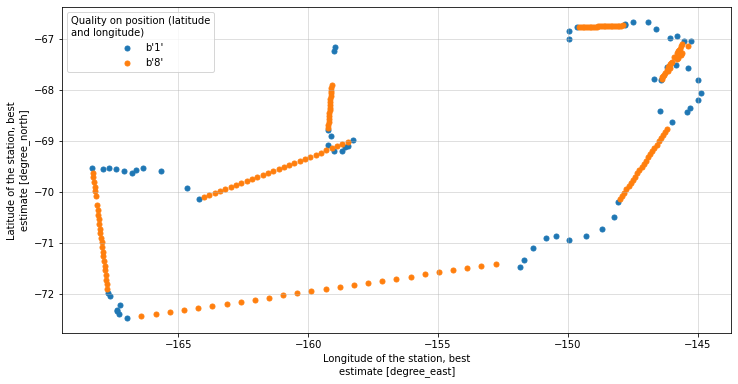

In [9]:
plt.figure(figsize=(12,6))
data.plot.scatter('LONGITUDE','LATITUDE',hue='POSITION_QC',s=25);
plt.grid(alpha=0.5)

# Profile timestamps and cycle numbers

Thanks to `xarray`'s datetime integration, the timestamps (`JULD`) are recognized in the correct format.

To confirm this, we extract the NumPy array of timestamp data from its `xarray` wrapper using `.values`, getting rid of any metadata.

Let's display the first 10 timestamps:

In [10]:
timestamps = data['JULD'].values

print(timestamps[:10])

['2014-04-01T16:45:31.001782016' '2014-04-11T22:55:23.002440192'
 '2014-04-22T06:15:07.000665600' '2014-05-02T12:26:46.001325312'
 '2014-05-12T18:06:03.001939968' '2014-05-22T23:43:17.002530048'
 '2014-06-02T05:18:41.000562432' '2014-06-12T10:55:02.001152512'
 '2014-06-22T16:29:26.001758464' '2014-07-02T22:06:23.002369024']


We check the object type to confirm the timestamps were converted into NumPy datetime objects:

In [11]:
print(type(timestamps[0]))

<class 'numpy.datetime64'>


We use similar syntax to examine the profile numbers and check if there are any missing profiles.

Notice that profiles 232 through 242 appear to be missing:

In [12]:
prof_nums = data['PROF_NUM'].values

display(prof_nums)

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 15

To further confirm this, we can compare the length of `prof_nums` with the final profile number. Since they do not match, we know that some profiles are missing:

In [13]:
len(prof_nums)

233

In [14]:
prof_nums[-1]

244.0

The missing profiles can be seen clearly in a scatter plot of profile number vs. time:

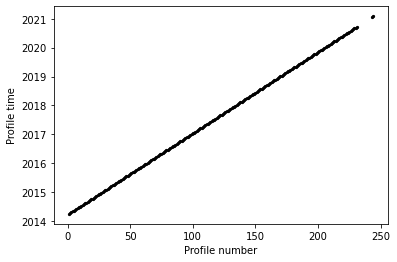

In [15]:
plt.scatter(prof_nums,timestamps,c='k',s=5)
plt.xlabel('Profile number')
plt.ylabel('Profile time');

# Check pressure coordinate

Displaying the quality-controlled pressure variable (`PRES_ADJUSTED`), we see that there seem to be 557 depth levels (`N_LEVELS`). However, this is just the maximum number of synthetic levels across all of the profiles. Not all profiles will necessarily have measurements at all 557 depth levels.

The attributes panel shows us that the units are decibars (dbar).

In [16]:
data['PRES_ADJUSTED']

<xarray.DataArray 'PRES_ADJUSTED' (PROF_NUM: 233, N_LEVELS: 557)>
[129781 values with dtype=float32]
Coordinates:
  * PROF_NUM  (PROF_NUM) float64 1.0 2.0 3.0 4.0 5.0 ... 230.0 231.0 243.0 244.0
Dimensions without coordinates: N_LEVELS
Attributes:
    long_name:       Sea water pressure, equals 0 at sea-level
    standard_name:   sea_water_pressure
    units:           decibar
    valid_min:       0.0
    valid_max:       12000.0
    C_format:        %7.1f
    FORTRAN_format:  F7.1
    resolution:      0.1
    axis:            Z

If we wanted to save a certain attribute (e.g., units) from the netCDF file, we'd use `xarray`'s `.attrs` syntax.

This yields a Python dictionary, so we index into the key-value dictionary pairs using brackets.

In [17]:
data['PRES_ADJUSTED'].attrs['units']

'decibar'

The 2-D array structure is clear when we extract the data into a NumPy array using `.values`.

In [18]:
data['PRES_ADJUSTED'].values

array([[   4.77    ,    6.57    ,    8.139999, ..., 1599.2899  ,
                nan,         nan],
       [   4.71    ,    6.61    ,    7.88    , ..., 1599.34    ,
                nan,         nan],
       [   4.6     ,    6.4     ,    8.15    , ..., 1599.39    ,
                nan,         nan],
       ...,
       [  14.944167,   16.944166,   19.144167, ...,         nan,
                nan,         nan],
       [   4.94    ,    6.54    ,    8.37    , ..., 1599.49    ,
        1699.9601  ,         nan],
       [   4.84    ,    6.54    ,    8.15    , ..., 1700.67    ,
                nan,         nan]], dtype=float32)

We can use indexing to pull out a specific profile — in this case, the first profile.

You can index by integer using `xarray`'s `.isel()` notation:

In [19]:
first_profile_pressure = data['PRES_ADJUSTED'].isel(PROF_NUM=0).values

Or using standard Python brackets indexing:

In [20]:
first_profile_pressure = data['PRES_ADJUSTED'].values[0]

Next, we examine the first 10 and last 10 pressure levels in the array.

The pressure array starts at around 5 dbar and the last valid measurement is at 1599 dbar. The rest of the array is padded with NaN (not a number) placeholder values. Notice that the sampling is at higher resolution (smaller intervals) near the surface than at depth.

In [21]:
display(first_profile_pressure[:10])

array([ 4.77    ,  6.57    ,  8.139999,  8.57    , 10.57    , 11.7     ,
       12.57    , 14.57    , 16.57    , 17.34    ], dtype=float32)

In [22]:
display(first_profile_pressure[-10:])

array([ 979.67  , 1000.14  , 1099.7999, 1200.19  , 1300.2799, 1399.9299,
       1499.83  , 1599.2899,       nan,       nan], dtype=float32)

# Difference in sampling between physical and chemical/biological sensors

Checking the first 50 vertical levels of the first salinity profile, we find that salinity measurements are provided at each level:

In [23]:
first_profile_salinity = data['PSAL_ADJUSTED'].values[0]

display(first_profile_salinity[0:50])

array([33.71165 , 33.711643, 33.71165 , 33.711655, 33.71164 , 33.711643,
       33.711643, 33.710644, 33.711647, 33.711647, 33.71165 , 33.71164 ,
       33.71164 , 33.71164 , 33.71165 , 33.711655, 33.711655, 33.71165 ,
       33.711643, 33.711655, 33.711655, 33.711636, 33.71165 , 33.71165 ,
       33.71165 , 33.71164 , 33.712196, 33.71265 , 33.711647, 33.71165 ,
       33.71165 , 33.71165 , 33.71165 , 33.712547, 33.712654, 33.712654,
       33.712654, 33.712654, 33.712658, 33.71366 , 33.715157, 33.715656,
       33.717648, 33.71965 , 33.7234  , 33.734653, 33.74165 , 33.760017,
       33.76365 , 33.79465 ], dtype=float32)

Chemical/biological sensors, such as nitrate, are sampled at a lower resolution. Synethetic levels with no data are represented by NaN values:

In [24]:
first_profile_nitrate = data['NITRATE_ADJUSTED'].values[0]

display(first_profile_nitrate[0:50])

array([      nan,       nan, 23.767195,       nan,       nan, 23.669868,
             nan,       nan,       nan, 23.643036,       nan,       nan,
       23.59084 ,       nan,       nan,       nan, 23.640648,       nan,
             nan, 23.723452,       nan,       nan,       nan, 23.785742,
             nan,       nan, 23.75382 ,       nan,       nan,       nan,
       23.823729,       nan,       nan, 23.883232,       nan,       nan,
             nan, 23.753033,       nan,       nan, 23.762346,       nan,
             nan,       nan, 23.826067,       nan,       nan, 24.173235,
             nan,       nan], dtype=float32)

# Plotting a vertical profile

If we try to make a line plot of a nitrate profile using `plt.plot()`, we see that the NaN values prevent the levels with valid data from being connected (except for a few deep measurements).

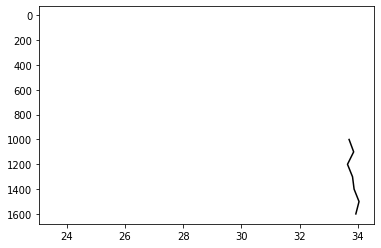

In [25]:
plt.figure()
plt.plot(first_profile_nitrate, first_profile_pressure, c='black')
plt.gca().invert_yaxis()

This is not an issue when creating a scatter plot, because `plt.scatter()` ignores NaN values.

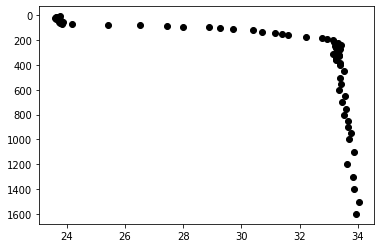

In [26]:
plt.figure()
plt.scatter(first_profile_nitrate, first_profile_pressure, c='black')
plt.gca().invert_yaxis()

To solve this, we use NumPy's `np.isnan()` function to create an array of booleans (True/False values), where True represents NaN values and False represents valid data:

In [27]:
mask_invalid_levels = np.isnan(first_profile_nitrate)

We invert this boolean mask using the `~` symbol, so True now represents valid data:

In [28]:
mask_valid_levels = ~mask_invalid_levels

Then we index into the NumPy array of data using the boolean mask we created. We find that the NaN values are ignored, and we now have a contiguous (albeit shorter) array of valid nitrate measurements.

In [29]:
valid_levels_only = first_profile_nitrate[mask_valid_levels]
display(valid_levels_only)

array([23.767195, 23.669868, 23.643036, 23.59084 , 23.640648, 23.723452,
       23.785742, 23.75382 , 23.823729, 23.883232, 23.753033, 23.762346,
       23.826067, 24.173235, 25.435059, 26.504519, 27.457779, 28.006113,
       28.87426 , 29.266598, 29.703598, 30.402884, 30.712244, 31.136389,
       31.395676, 31.61192 , 32.231953, 32.769505, 32.951447, 33.14131 ,
       33.176937, 33.320778, 33.241455, 33.40722 , 33.217785, 33.25152 ,
       33.37784 , 33.34078 , 33.270107, 33.31136 , 33.153275, 33.343388,
       33.3542  , 33.231377, 33.25233 , 33.259487, 33.398945, 33.380924,
       33.52171 , 33.394306, 33.41701 , 33.333023, 33.53821 , 33.461956,
       33.591656, 33.523865, 33.64259 , 33.67    , 33.74902 , 33.69532 ,
       33.852528, 33.6409  , 33.813503, 33.867382, 34.03679 , 33.92741 ],
      dtype=float32)

We can also accomplish this in a single step, as shown below. Masking out the NaN values allows us to plot the full nitrate vertical profile.

We can add axis labels and a title to the plot, including the timestamp of the profile.



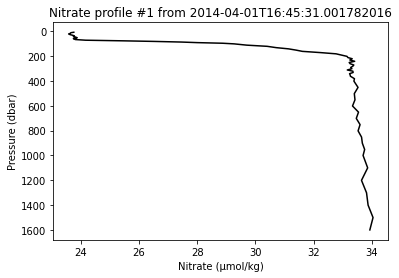

In [30]:
plt.figure()
plt.plot(first_profile_nitrate[~np.isnan(first_profile_nitrate)], 
         first_profile_pressure[~np.isnan(first_profile_nitrate)], c='black')
plt.gca().invert_yaxis()
plt.xlabel('Nitrate (µmol/kg)')
plt.ylabel('Pressure (dbar)')
plt.title('Nitrate profile #1 from {0}'.format(timestamps[0]));

# Checking QC flags and comparing raw and adjusted fields


It is important to be use quality control (QC) flags to exclude poor-quality data in each profile. See the chart below for the meaning of QC flags 0 through 9 for real-time and delayed-mode data. *Note: If the chart is not displaying in your browser, you can view it at [this link](https://drive.google.com/file/d/1C_dOidL6HFvmrKTWo1x_yWpTYoWMGhCC/view?usp=sharing).*

![test](https://drive.google.com/uc?export=download&id=1C_dOidL6HFvmrKTWo1x_yWpTYoWMGhCC)

*Source: Argo [FAQ page](https://argo.ucsd.edu/data/how-to-use-argo-files/)*

Here, we create time-depth sections of nitrate (`NITRATE` and `NITRATE_ADJUSTED`) and the corresponding QC flags (`NITRATE_QC` and `NITRATE_ADJUSTED_QC`) using Matplotlib's `pcolor()` function to show the actual sampling levels.

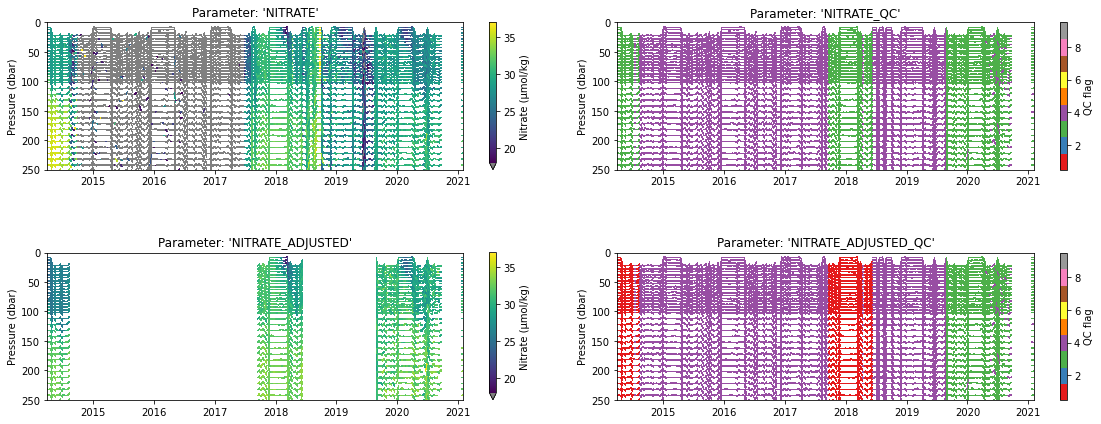

In [31]:
# Stack NumPy array of datetimes to create a 2D grid
time_2D = np.tile(data['JULD'].values,(len(data['N_LEVELS']),1)).T

# Function for repetitive parts of plot
def config_depth_section(cbar_label,title):
  plt.ylim([0,250])
  plt.gca().invert_yaxis()
  plt.ylabel('Pressure (dbar)')
  if 'Nitrate' in cbar_label: extend = 'min'
  else:                       extend = 'neither'
  plt.colorbar(label=cbar_label,extend=extend)
  plt.title(title)

# Create subplots
plt.figure(figsize=(16,6))
plt.subplot(2,2,1)
cmap = plt.get_cmap('viridis')
cmap.set_under('0.5')
plt.pcolor(time_2D,data['PRES_ADJUSTED'].values,data['NITRATE'].values,cmap=cmap,vmin=18,vmax=37)
config_depth_section('Nitrate (µmol/kg)',"Parameter: 'NITRATE'")

plt.subplot(2,2,2)
plt.pcolor(time_2D,data['PRES_ADJUSTED'].values,data['NITRATE_QC'].values.astype(float),cmap='Set1',vmin=0.5,vmax=9.5)
config_depth_section('QC flag',"Parameter: 'NITRATE_QC'")

plt.subplot(2,2,3)
plt.pcolor(time_2D,data['PRES_ADJUSTED'].values,data['NITRATE_ADJUSTED'].values,cmap=cmap,vmin=18,vmax=37)
config_depth_section('Nitrate (µmol/kg)',"Parameter: 'NITRATE_ADJUSTED'")

plt.subplot(2,2,4)
plt.pcolor(time_2D,data['PRES_ADJUSTED'].values,data['NITRATE_ADJUSTED_QC'].values.astype(float),cmap='Set1',vmin=0.5,vmax=9.5)
config_depth_section('QC flag',"Parameter: 'NITRATE_ADJUSTED_QC'")

plt.tight_layout(h_pad=5,w_pad=3)

In the plot above:

* At top left, we observe that the raw nitrate data (`NITRATE`) contains many spurious values. Some are obviously wrong (e.g., those in gray, which are actually negative values), while some are less obviously wrong (e.g., those in late 2018 and early 2019).

* At top right, the automated QC flags (`NITRATE_QC`) show a mix of 3 (bad data that are potentially correctable) and 4 (bad data that are not correctable).

* At bottom left, the adjusted nitrate data (`NITRATE_ADJUSTED`) exclude both the periods of obviously and less obviously wrong data, and also include an offset correction.

* At bottom right, the adjusted QC flags (`NITRATE_ADJUSTED_QC`) are now a mix of 1 (good data), 3 (bad data that are potentially correctable), and 4 (bad data that are not correctable). Since these have been reviewed by the BGC data quality team, they are more trustworthy than the raw QC flags (`NITRATE_QC`).

<br>

**The lesson here is twofold: always use the `_ADJUSTED` versions of parameters, and check the QC flags!**

<br>

# Interpolating time-depth sections

**Interpolation function**

As you've seen above, floats sample differently on each profile. To plot a nicer-looking time-depth section, we need to interpolate each profile to a uniform pressure (z) coordinate. We do this using SciPy's [`interpolate.griddata()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html) function, as described here:

1. First, we create simple functions to convert the datetime (x) coordinate between NumPy's datetime64 format and Python's floating-point number format, as `griddata()` requires floats, not datetimes.

2. Next, we create a function (`interpolate_depth_section()`) to interpolate the data for any float parameter. In the function, a uniform pressure coordinate with a vertical resolution of 1.0 dbar is created. NumPy's `meshgrid()` function is used to convert the 1-D time and pressure coordinates to 2-D time and pressure grids. The 2-D time, pressure, and parameter data arrays are flattened into 1-D arrays in preparation for interpolation.

3. If one specifies a list of integer QC flags to retain using the function argument `specify_qc_flags`, a mask will be created to extract only data matching those QC flags for interpolation.

4. Finally, data levels without data (i.e., those with NaN values) are removed, and the 1-D time, pressure, and parameter values are interpolated to the 2-D time and pressure grids. The function returns all five of these.

In [32]:
# Function to convert an array from NumPy datetime64 to Python float format
def datetime_to_float(dt):
  return (dt - np.datetime64('1900-01-01')) / np.timedelta64(1,'D')

# Function to convert an array from Python float to NumPy datetime64 format
def float_to_datetime(nums):
  return (nums * np.timedelta64(1,'D')) + np.datetime64('1900-01-01')

# Function to interpolate data from a specified float parameter to a uniform time and pressure grid
def interpolate_depth_section(param_name,specify_qc_flags=None,pres_interval=1.0):
  """
  Arguments:
      param_name: string with netCDF file parameter name (e.g., 'TEMP_ADJUSTED') to interpolate
      specify_qc_flags: None to ignore QC flags
                        or a list of QC flags (e.g., [1,2,3]) indicating which data to retain before interpolation
      pres_interval: vertical resolution for interpolating pressure (z) axis (default: 1.0 dbar)
  
  Returns:
      time_coord: 1-D NumPy array with original profile timestamps in np.datetime64 format
      pres_coord: 1-D NumPy array with a uniform pressure (z) coordinate from 0 dbar to the deepest recorded
                  pressure value, at a resolution of <pres_interval> dbar
      time_grid: 2-D NumPy array with the meshed grid of time_coord
      pres_grid: 2-D NumPy array with the meshed grid of pres_coord
      param_gridded: 2-D NumPy array with the interpolated parameter values at the locations of time_grid and pres_grid

  """

  # New grid points
  time_coord = data['JULD'].values
  pres_coord = np.arange(0,data['PRES'].max(),pres_interval)
  time_grid, pres_grid = np.meshgrid(time_coord,pres_coord)
  time_grid = datetime_to_float(time_grid)     # Convert from np.datetime64 to float

  # 1-D (flattened) versions of old grids and parameter values
  time_1D = np.tile(data['JULD'].values,(len(data['N_LEVELS']),1)).T.flatten()
  pres_1D = data['PRES'].values.flatten()
  param_1D = data[param_name].values.flatten()
  if param_1D.dtype == object: param_1D = param_1D.astype(float)  # Convert QC flags from dtype 'object' to float

  # Extract only values matching specified QC flags
  if specify_qc_flags is not None:
    qc_1D = data[param_name + '_QC'].values.astype(float).flatten()
    qc_mask = np.tile(False,len(qc_1D))
    for qc_flag in specify_qc_flags:
      qc_mask = np.logical_or(qc_mask,qc_1D == qc_flag)
    time_1D = time_1D[qc_mask]
    pres_1D = pres_1D[qc_mask]
    param_1D = param_1D[qc_mask]

  # Remove NaN values before interpolation
  time_1D = datetime_to_float(time_1D[~np.isnan(param_1D)])       # Convert from np.datetime64 to float
  pres_1D = pres_1D[~np.isnan(param_1D)]
  param_1D = param_1D[~np.isnan(param_1D)]

  # Interpolate from irregular points to grid
  param_gridded = interpolate.griddata((time_1D,pres_1D),param_1D,(time_grid,pres_grid),method='linear')

  # Return coordinates, grid, and gridded data
  return time_coord, pres_coord, float_to_datetime(time_grid), pres_grid, param_gridded

**Interpolate and plot raw dissolved oxygen section**

We use the function created above to interpolate the raw dissolved oxygen (`DOXY`) data. Since the interpolated data is on a uniform grid, we can use Matplotlib's `pcolormesh()` function to create a shaded pseudocolor time-depth plot. We limit depths to 0-250 m to focus on the upper ocean.

Notice that there is one profile in late 2018 that is very clearly spurious.

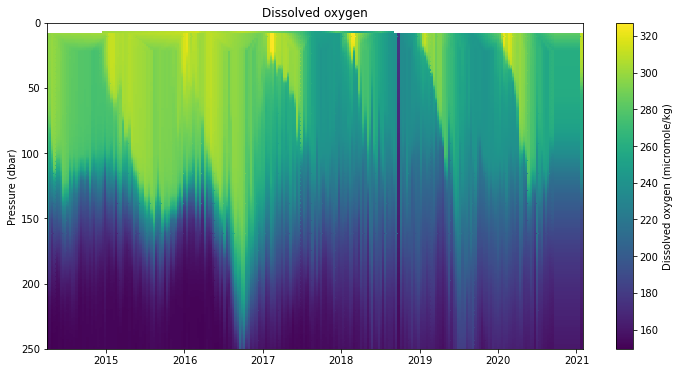

In [33]:
# Interpolate data
param_name = 'DOXY'
time_coord, pres_coord, time_grid, pres_grid, param_gridded = interpolate_depth_section(param_name)

# Plot depth section of upper ocean only
plt.figure(figsize=(12,6))
plt.pcolormesh(time_grid,pres_grid,param_gridded)
plt.ylim([0,250])
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.colorbar(label='{0} ({1})'.format(data[param_name].long_name,data[param_name].units))
plt.title(data[param_name].long_name);

**Interpolate and plot raw dissolved oxygen QC flags**

We can use the function to interpolate QC flags as well. From this, it becomes apparent that there are actually two profiles with bad data that must be excluded.

This illustrates why it is important to both examine QC flags and use the `_ADJUSTED` fields.

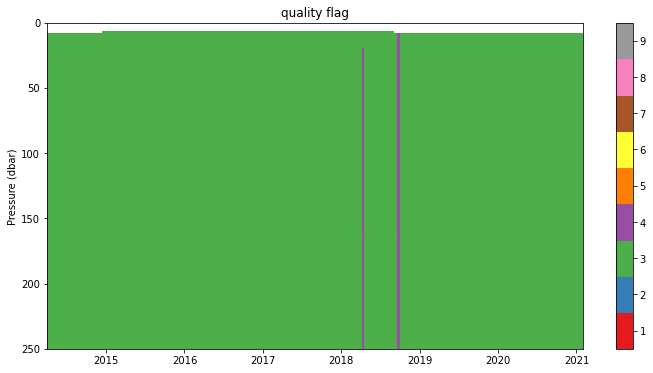

In [34]:
# Interpolate data
param_name = 'DOXY_QC'
time_coord, pres_coord, time_grid, pres_grid, param_gridded = interpolate_depth_section(param_name)

# Plot depth section of upper ocean only
plt.figure(figsize=(12,6))
plt.pcolormesh(time_grid,pres_grid,param_gridded,cmap='Set1',vmin=0.5,vmax=9.5)
plt.ylim([0,250])
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.colorbar()
plt.title(data[param_name].long_name);

**Interpolate and plot adjusted dissolved oxygen section**

Here, we interpolate and plot the adjusted dissolved oxygen data. We also specify to include only data with a QC flag of '1' (good data).

The spurious profiles are now gone.

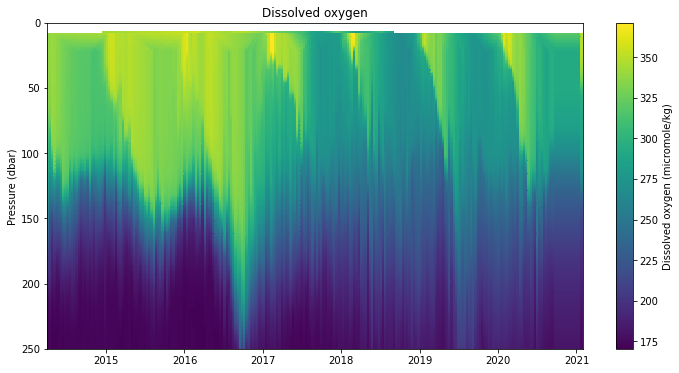

In [35]:
# Interpolate data
param_name = 'DOXY_ADJUSTED'
time_coord, pres_coord, time_grid, pres_grid, param_gridded = interpolate_depth_section(param_name,specify_qc_flags=[1])

# Plot depth section of upper ocean only
plt.figure(figsize=(12,6))
plt.pcolormesh(time_grid,pres_grid,param_gridded)
plt.ylim([0,250])
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.colorbar(label='{0} ({1})'.format(data[param_name].long_name,data[param_name].units))
plt.title(data[param_name].long_name);

**Interpolate and plot adjusted temperature section**

You can use this code to interpolate and plot a depth section of any parameter, like temperature here. Try modifying the code to plot a different parameter!

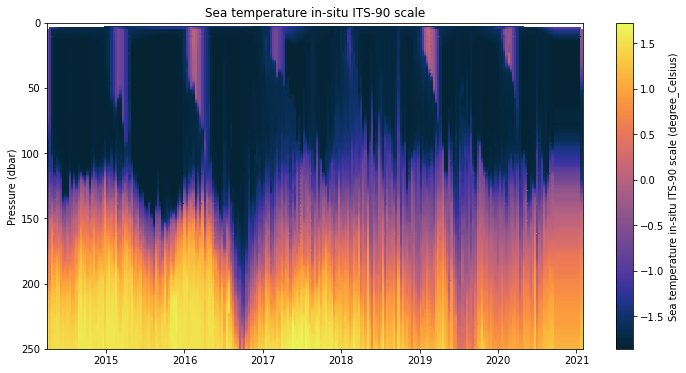

In [36]:
# Interpolate data
param_name = 'TEMP_ADJUSTED'
time_coord, pres_coord, time_grid, pres_grid, param_gridded = interpolate_depth_section(param_name,specify_qc_flags=[1])

# Plot depth section of upper ocean only
plt.figure(figsize=(12,6))
plt.pcolormesh(time_grid,pres_grid,param_gridded,cmap=cmocean.cm.thermal)
plt.ylim([0,250])
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.colorbar(label='{0} ({1})'.format(data[param_name].long_name,data[param_name].units))
plt.title(data[param_name].long_name);

# Examining data from GO-BGC floats in North Atlantic

**Downloading data from multiple floats using time/space/sensor criteria**

Earlier, we used the function `argo_gdac()`, created at the top of this notebook, to download data from a single float. Here we use it to download data from multiple GO-BGC floats deployed recently in the North Atlantic.

Informed by the [float array maps](https://www.go-bgc.org/array-status#locations) on the GO-BGC website, we specify latitude and longitude bounds, a start date of Jan. 2021, and require floats to have a pH sensor.

This yields 11 floats that match these criteria, all of which are GO-BGC floats (see the GO-BGC float table [here](http://go-bgc.ucsd.edu/GOBGC_float_performance.html)).

In [37]:
wmoids, gdac_index, downloaded_filenames \
                   = argo_gdac(lat_range=[5,45],lon_range=[-75,-45],
                               start_date=datetime(2021,1,1),end_date=datetime.today(),
                               sensors=['PH_IN_SITU_TOTAL'],floats=None,
                               overwrite_index=False,overwrite_profiles=False,
                               skip_download=False,download_individual_profs=False,
                               save_to=natl_dir,verbose=True)

>>> File argo_synthetic-profile_index.txt already exists. Leaving current version.
>>> File 5906339_Sprof.nc already exists. Leaving current version.
>>> File 5906340_Sprof.nc already exists. Leaving current version.
>>> File 5906342_Sprof.nc already exists. Leaving current version.
>>> File 5906343_Sprof.nc already exists. Leaving current version.
>>> File 5906434_Sprof.nc already exists. Leaving current version.
>>> File 5906435_Sprof.nc already exists. Leaving current version.
>>> File 5906436_Sprof.nc already exists. Leaving current version.
>>> File 5906437_Sprof.nc already exists. Leaving current version.
>>> File 5906438_Sprof.nc already exists. Leaving current version.
>>> File 5906439_Sprof.nc already exists. Leaving current version.
>>> File 5906440_Sprof.nc already exists. Leaving current version.


In [38]:
print('Number of floats meeting criteria:', len(downloaded_filenames))

Number of floats meeting criteria: 11


**Loading data from each float into an interactive map**

In the code below, we use the [Plotly](https://plotly.com/python/) library to create an interactive visualization of these floats' trajectories. We use a loop to load each float's data file, extract latitude and longitude, and calculate the values of a specified parameter that are nearest to the surface for each profile.

You can pan and zoom around the Plotly using your mouse, trackpad, or the controls at the top right.

Try changing the value of the variable `which_param` below to plot a different set of near-surface measurements!

In [39]:
# Choose whether to plot temperature ('temp'), salinity ('psal'), chlorophyll ('chla'), backscatter ('bbp'),
#                        dissolved oxygen ('doxy'), nitrate ('NO3'), or pH ('pH') on map
which_param = 'temp'

# Set up Plotly canvas
fig = go.Figure(go.Scattergeo())

# Iterate through floats downloaded
for filename in os.listdir(natl_dir):

  # Load float data
  data = xr.open_dataset(natl_dir + filename)

  # Organize data for hover text
  hov = data[['CYCLE_NUMBER','JULD','LATITUDE','LONGITUDE']].to_pandas()

  # Calculate near-surface parameter values
  if which_param == 'temp':
    param_name = 'TEMP_ADJUSTED'; cmin = 15; cmax = 30; colorscale = 'Thermal'
    title = 'Temperature (°C)'; hover_str = 'Near-surface temperature: %{customdata[4]:.02f}°C'
  elif which_param == 'psal':
    param_name = 'PSAL_ADJUSTED'; cmin = 35.5; cmax = 37.5; colorscale = 'haline'
    title = 'Salinity (PSU)'; hover_str = 'Near-surface salinity: %{customdata[4]:.02f} PSU'
  elif which_param == 'chla':
    param_name = 'CHLA_ADJUSTED'; cmin = 0.0; cmax = 0.5; colorscale = 'algae'
    title = 'Chlorophyll-a (mg/m^3)'; hover_str = 'Near-surface chlorophyll-a: %{customdata[4]:.02f} mg/m^3'
  elif which_param == 'bbp':
    param_name = 'BBP700'; cmin = 0.0; cmax = 0.001; colorscale = 'matter'
    title = 'Particle backscattering at 700 nm (m^-1)'; hover_str = 'Near-surface backscattering: %{customdata[4]:.05f} m^-1'
  elif which_param == 'doxy':
    param_name = 'DOXY_ADJUSTED'; cmin = 190; cmax = 240; colorscale = 'ice'
    title = 'Dissolved oxygen (µmol/kg)'; hover_str = 'Near-surface dissolved oxygen: %{customdata[4]:.02f} µmol/kg'
  elif which_param == 'NO3':
    param_name = 'NITRATE_ADJUSTED'; cmin = 0.0; cmax = 1.5; colorscale = 'PuRd'
    title = 'Nitrate (µmol/kg)'; hover_str = 'Near-surface nitrate: %{customdata[4]:.02f} µmol/kg'
  elif which_param == 'pH':
    param_name = 'PH_IN_SITU_TOTAL_ADJUSTED'; cmin = 7.95; cmax = 8.10; colorscale = 'Sunset'
    title = 'pH'; hover_str = 'Near-surface pH: %{customdata[4]:.02f}'
  hov['NEAR_SURF'] = [prof[~np.isnan(prof)][0] if len(prof[~np.isnan(prof)]) > 1 else np.NaN for prof in data[param_name].values]

  # Add float trajectory to map
  fig.add_trace(go.Scattermapbox(mode = 'lines',
                                 lon = hov['LONGITUDE'],
                                 lat = hov['LATITUDE'],
                                 marker = go.scattermapbox.Marker(color='white',size=5),
                                 showlegend = False))
  fig.add_trace(go.Scattermapbox(mode = 'markers',
                                 lon = hov['LONGITUDE'],
                                 lat = hov['LATITUDE'],
                                 marker = go.scattermapbox.Marker(color=hov['NEAR_SURF'],size=10,cmin=cmin,cmax=cmax,
                                                                  colorscale=colorscale,
                                                                  colorbar={'title':title,'titleside':'right'},
                                                                  showscale=True),
                                 customdata = hov.values,
                                 hovertemplate = 'Profile #: %{customdata[0]}<br>Time: %{customdata[1]}<br>' + \
                                    'Latitude: %{customdata[2]:.02f}<br>Longitude: %{customdata[3]:.02f}<br>' + hover_str,
                                 name = 'Float: ' + data['PLATFORM_NUMBER'].values[0].decode('utf-8'),
                                 showlegend = False))

# Formatting and basemap
fig.update_layout(margin = {'l':0,'t':0,'b':0,'r':0},
                  height = 500,
                  width = 1000,
                  autosize = False,
                  hovermode = 'closest',
                  mapbox = {'style':'open-street-map',
                            'center':{'lon':-60,'lat':25},
                            'zoom':3.0})